<a href="https://colab.research.google.com/github/hackerpranavpandey/SOI_Mission_Mars_Terrain/blob/main/Train_ResNet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/Mission_Mars/train.csv'

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
import os
import torch.nn as nn
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
df=pd.read_csv(path)

In [ ]:
import numpy as np
print(f"the shape of label csv fie is : {np.shape(df)}")
print(f" all the unique labels present in the dataset is:{np.unique(df.iloc[:,1:])}")

the shape of label csv fie is : (6201, 2)
 all the unique labels present in the dataset is:['bright dune' 'crater' 'dark dune' 'impact ejecta' 'other' 'slope streak'
 'spider' 'swiss cheese']


In [ ]:
print(df.iloc[:,1:].value_counts())

Class        
other            3651
crater           1062
bright dune       597
slope streak      335
swiss cheese      223
dark dune         216
spider             66
impact ejecta      51
Name: count, dtype: int64


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
images=[]
labels=[]
def image_process():
  images_path='/content/drive/MyDrive/Mission_Mars/train_dataset'
  for image_path in os.listdir(images_path):
    label=image_path.split('.')[0]
    label=int(label)-1
    label=df.iloc[label,1:]
    labels.append(label[0])
    image_name=os.path.join(images_path,image_path)
    image_array=cv2.imread(image_name,cv2.IMREAD_GRAYSCALE)
    images.append(image_array)
image_process()

other


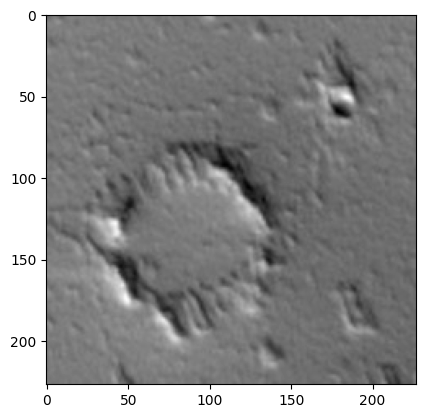

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[246],cmap="gray")
print(labels[246])

In [ ]:
## resizing the image
## also converting it to rgb format
resized_images=[]
def reshape():
  for image in images:
    new_array=np.array(cv2.resize(image,(216, 216)))
    rgb_array = np.stack((new_array,)*3,axis=-1)
    resized_images.append(rgb_array)
reshape()

In [ ]:
np.shape(resized_images),np.shape(labels)

((6201, 216, 216, 3), (6201,))

In [ ]:
## now lets do some data augementation for images with less  number to decrease the model underfitting
def image_augmentation():
  t=len(resized_images)
  for i in range(0,t):
    rotated_array_90=cv2.rotate(resized_images[i], cv2.ROTATE_90_CLOCKWISE)
    rotate_180=cv2.rotate(resized_images[i], cv2.ROTATE_180)
    rotated_array_270 = cv2.rotate(resized_images[i], cv2.ROTATE_90_COUNTERCLOCKWISE)
    if labels[i]=='crater':
      resized_images.append(rotate_180)
      labels.append(labels[i])
    elif labels[i]=="bright dune" or labels[i]=="slope streak" or labels[i]=="swiss cheese" or labels[i]=="dark dune":
      resized_images.append(rotated_array_90)
      labels.append(labels[i])
      resized_images.append(rotate_180)
      labels.append(labels[i])
    elif labels[i]=="spider" or labels[i]=="impact ejecta":
      resized_images.append(rotated_array_90)
      labels.append(labels[i])
      resized_images.append(rotate_180)
      labels.append(labels[i])
      resized_images.append(rotated_array_270)
      labels.append(labels[i])
image_augmentation()

In [ ]:
labels[0],np.shape(labels),np.shape(resized_images)

('swiss cheese', (10356,), (10356, 216, 216, 3))

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(labels)
encoded_mapping = {label: encoded_value for label, encoded_value in zip(target,labels)}
print(encoded_mapping)

{7: 'swiss cheese', 4: 'other', 0: 'bright dune', 1: 'crater', 3: 'impact ejecta', 2: 'dark dune', 5: 'slope streak', 6: 'spider'}


In [ ]:
np.shape(labels),np.shape(resized_images)

((10356,), (10356, 216, 216, 3))

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
resized_images = np.array(resized_images)
labels = np.array(labels)
train_images, val_images, train_labels, val_labels = train_test_split(resized_images, target, test_size=0.2, random_state=42)

In [ ]:
unique,counts=np.unique(train_labels, return_counts=True)
print(unique,counts)

[0 1 2 3 4 5 6 7] [1436 1679  524  174 2920  800  218  533]


In [ ]:
unique,counts=np.unique(val_labels,return_counts=True)
print(unique,counts)

[0 1 2 3 4 5 6 7] [355 445 124  30 731 205  46 136]


In [ ]:
import torch
from torch.utils.data import Dataset
## below class inherit dataset class from above import
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self):        ## when called willl return len(images)
        return len(self.images)
    def __getitem__(self, idx):
        image = self.images[idx]   ## get image at index idx
        label = self.labels[idx]   ## get label
        image = Image.fromarray(image)   ## convert it to PIL image to apply any tranformation
        if self.transform:
            image = self.transform(image)    ## now apply transformation
        return image, label

In [ ]:
from torchvision import transforms
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   ## har 3 channel ke liye R,G,B these mean values are used for imageNet dataset
                                     ])

In [ ]:
from torch.utils.data import DataLoader
## Pytorch will automatically call when needed like for len(images) it will call __(len)__ function
## when we will call train_image,train_labels it will call __getitem__
train_dataset = CustomDataset(train_images, train_labels, transform=data_transforms) ## object of class CustomDataset
val_dataset = CustomDataset(val_images, val_labels, transform=data_transforms)
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=4)   ## shuffle=True for more randomness during training
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False,num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for image,label in train_dataset:
  print(image)
  print(label)
  break

tensor([[[0.8961, 0.9132, 0.9303,  ..., 0.5707, 0.5878, 0.6049],
         [0.9132, 0.9132, 0.9303,  ..., 0.5707, 0.5878, 0.6221],
         [0.9132, 0.9132, 0.9132,  ..., 0.5878, 0.6049, 0.6392],
         ...,
         [0.5364, 0.5364, 0.5193,  ..., 0.4679, 0.4851, 0.5022],
         [0.5364, 0.5193, 0.5022,  ..., 0.4851, 0.4851, 0.5022],
         [0.5364, 0.5193, 0.5022,  ..., 0.4851, 0.4851, 0.4851]],

        [[1.0455, 1.0630, 1.0805,  ..., 0.7129, 0.7304, 0.7479],
         [1.0630, 1.0630, 1.0805,  ..., 0.7129, 0.7304, 0.7654],
         [1.0630, 1.0630, 1.0630,  ..., 0.7304, 0.7479, 0.7829],
         ...,
         [0.6779, 0.6779, 0.6604,  ..., 0.6078, 0.6254, 0.6429],
         [0.6779, 0.6604, 0.6429,  ..., 0.6254, 0.6254, 0.6429],
         [0.6779, 0.6604, 0.6429,  ..., 0.6254, 0.6254, 0.6254]],

        [[1.2631, 1.2805, 1.2980,  ..., 0.9319, 0.9494, 0.9668],
         [1.2805, 1.2805, 1.2980,  ..., 0.9319, 0.9494, 0.9842],
         [1.2805, 1.2805, 1.2805,  ..., 0.9494, 0.9668, 1.

torch.Size([3, 256, 256])


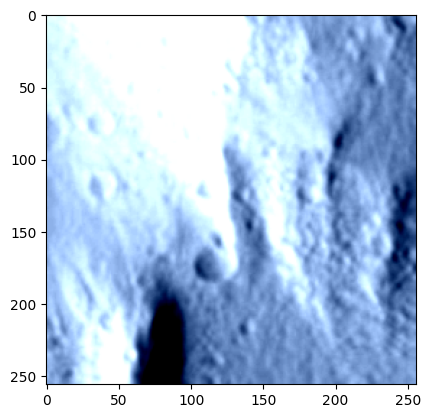

In [ ]:
for image,label in train_dataset:
  print(image.shape)
  image=image.permute(1,2,0)
  plt.imshow(image,cmap="gray")
  break

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet152(pretrained=True)   ## lets use inbuilt resnet50 which is better than resnet18 or canuse restnet 152
num_ftrs = model.fc.in_features       ## this give access to last fully connected layer

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 69.9MB/s]


In [ ]:
# for param in model.parameters():
#   param.requires_grad=False
model.fc = nn.Linear(num_ftrs, len(np.unique(labels)))  # adjust the output layer to match the number of classes
# model.fc.requires_grad=True
model = model.to(device)    ## upload to gpu
criterion = nn.CrossEntropyLoss()   ## loss function -ylog(y)
optimizer = optim.Adam(model.parameters(), lr=0.001)    ## optimizer as adam with lr=0.001
## learning rate scheduler here it reduces learning rate by a factor of gamma every step_size epoch
# schedular=optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
# model

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/40, Train Loss: 0.7149, Train Accuracy: 75.53%, Val Loss: 0.6463, Val Accuracy: 79.10%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 2/40, Train Loss: 0.4709, Train Accuracy: 83.98%, Val Loss: 0.7551, Val Accuracy: 76.06%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 3/40, Train Loss: 0.3551, Train Accuracy: 88.00%, Val Loss: 0.3119, Val Accuracy: 89.62%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 4/40, Train Loss: 0.2640, Train Accuracy: 91.22%, Val Loss: 0.3510, Val Accuracy: 89.00%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 5/40, Train Loss: 0.2067, Train Accuracy: 93.13%, Val Loss: 0.4236, Val Accuracy: 87.69%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 6/40, Train Loss: 0.1844, Train Accuracy: 93.51%, Val Loss: 0.2533, Val Accuracy: 91.22%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 7/40, Train Loss: 0.1331, Train Accuracy: 95.46%, Val Loss: 0.4526, Val Accuracy: 87.07%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 8/40, Train Loss: 0.1209, Train Accuracy: 95.82%, Val Loss: 0.2371, Val Accuracy: 92.42%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 9/40, Train Loss: 0.1141, Train Accuracy: 96.19%, Val Loss: 0.1968, Val Accuracy: 93.53%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 10/40, Train Loss: 0.0825, Train Accuracy: 97.20%, Val Loss: 0.2764, Val Accuracy: 91.07%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 11/40, Train Loss: 0.1051, Train Accuracy: 96.44%, Val Loss: 0.2924, Val Accuracy: 90.83%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 12/40, Train Loss: 0.1101, Train Accuracy: 96.29%, Val Loss: 0.3096, Val Accuracy: 89.77%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 13/40, Train Loss: 0.0827, Train Accuracy: 97.46%, Val Loss: 0.2668, Val Accuracy: 91.46%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 14/40, Train Loss: 0.0531, Train Accuracy: 98.27%, Val Loss: 0.2455, Val Accuracy: 93.44%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 15/40, Train Loss: 0.0543, Train Accuracy: 98.30%, Val Loss: 0.2787, Val Accuracy: 92.33%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 16/40, Train Loss: 0.0619, Train Accuracy: 97.98%, Val Loss: 0.2479, Val Accuracy: 93.10%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 17/40, Train Loss: 0.0586, Train Accuracy: 97.96%, Val Loss: 0.2017, Val Accuracy: 93.53%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 18/40, Train Loss: 0.0335, Train Accuracy: 98.89%, Val Loss: 0.2842, Val Accuracy: 92.81%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 19/40, Train Loss: 0.0623, Train Accuracy: 97.88%, Val Loss: 0.2701, Val Accuracy: 93.24%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 20/40, Train Loss: 0.0413, Train Accuracy: 98.52%, Val Loss: 0.2426, Val Accuracy: 93.68%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 21/40, Train Loss: 0.0577, Train Accuracy: 98.12%, Val Loss: 0.2807, Val Accuracy: 91.99%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


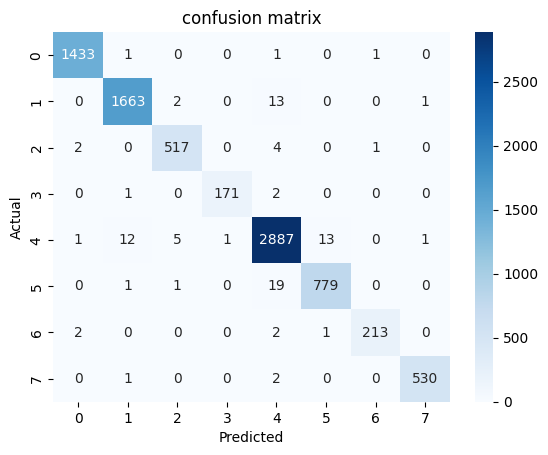

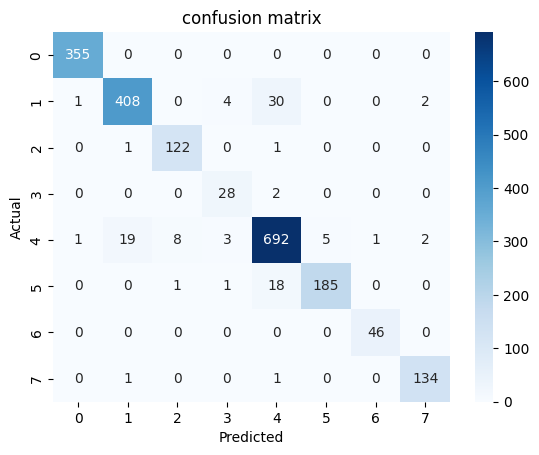

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
save_path = '/content/drive/MyDrive/model.pth'
num_classes=8
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40):   ## train for n number of epochs
    for epoch in range(num_epochs):
        model.train()     ## train the model with random values
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels_train=[]
        all_pred_train=[]
        for inputs, labels in train_loader:      ## __getitem__ gets called here for 32 images,labels as batch size
            inputs, labels = inputs.to(device), labels.to(device)  ## gpu
            optimizer.zero_grad()   ## make gradient 0
            outputs = model(inputs)   ## get the output
            loss = criterion(outputs, labels)    ## compute loss using cross entropy
            loss.backward()          ## find differentiation
            optimizer.step()     ## do optimization
            running_loss += loss.item()       ## add to loss
            _, predicted = torch.max(outputs, 1)         ## ye index dega max value ka
            total_train += labels.size(0)      ## total trained samples
            correct_train += (predicted == labels).sum().item()      ## get corrected predicted one values
            all_labels_train.extend(labels.cpu().numpy())  ## for confusion matrix
            all_pred_train.extend(predicted.cpu().numpy())  ## for confusion matrix
        train_loss = running_loss / len(train_loader)          ## compute training loss
        train_accuracy = 100 * correct_train / total_train        ## training ki accuracy
        model.eval()    ## model ko evaluation mode me dalo taki validation pe check kar sake usme drop out layer koi unit drop nhi karte hai aur bactch normalization current statistic use karta hai
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        all_labels_val=[]
        all_pred_val=[]
        with torch.no_grad():  ## ye isliye taki koi bhi gradient na ho iske baad like differentiation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                max_value,predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_labels_val.extend(labels.cpu().numpy())
                all_pred_val.extend(predicted.cpu().numpy())
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        train_conf_matrix=confusion_matrix(all_labels_train,all_pred_train,labels=list(range(num_classes)))
        test_conf_matrix=confusion_matrix(all_labels_val,all_pred_val,labels=list(range(num_classes)))
        if val_accuracy>94 or epoch==39:
          sns.heatmap(train_conf_matrix,annot=True,fmt='d',cmap="Blues",xticklabels=list(range(num_classes)),yticklabels=list(range(num_classes)))
          plt.title('confusion matrix')
          plt.xlabel('Predicted')
          plt.ylabel('Actual')
          plt.show()
          sns.heatmap(test_conf_matrix,annot=True,fmt='d',cmap="Blues",xticklabels=list(range(num_classes)),yticklabels=list(range(num_classes)))
          plt.title('confusion matrix')
          plt.xlabel('Predicted')
          plt.ylabel('Actual')
          plt.show()
          torch.save(model.state_dict(),save_path)
          break
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40)